# Problém batohu
Základ problému
Je dáno

- celé číslo `n` (počet věcí)
- celé číslo `M` (kapacita batohu)
- konečná množina `V = {v1, v2, ... ,vn }` (hmotnosti věcí)
- konečná množina `C = {c1, c2, ... ,cn }` (ceny věcí)

In [6]:
import enum

class Method(enum.Enum):
    BF = 1    # Brute Force method
    BAB = 2   # Branch and Bound method

In [7]:
class Knapsack:
    def __init__(self, initString):
        arr = initString.split()
        decisionProblem = int(arr[0]) < 0
        items = arr[4:] if decisionProblem else arr[3:]
        
        self.id = int(arr[0])
        self.n = int(arr[1])
        self.M = int(arr[2])
        self.B = int(arr[3]) if decisionProblem else None
        self.weights = list(map(lambda x: int(x), items[::2]))
        self.prices = list(map(lambda x: int(x), items[1::2]))
        self.solution = None
        self.solutionPrice = None
        self.decisionSolution = None
        self.initString = initString
        self.outputString = None
        self.stepsToSolve = None
        
    def __str__ (self):
        res = "KNAPSACK " + str(self.id) + "\n"
        res += "-----------------------------------" + "\n"
        res += "n = " + str(self.n) + "\tM = " + str(self.M) + "\tB = " + (str(self.B) if self.B else "--") + "\n"
        
        for (i, x) in enumerate(self.weights):
            res += "#" + str(i) + "\t" + str(x) + "\t" + str(self.prices[i]) + "\t\t" + (str(self.solution[i]) if self.solution is not None else "") + "\n"
        res += "-----------------------------------" + "\n"
        res += "CONSTRUCTIVE PROBLEM SOLUTION:\t" + (str(self.solutionPrice) if self.solutionPrice is not None else "--") + "\n"
        res += "DECISION PROBLEM SOLUTIONS:\t#" + (str(len(self.decisionSolution)) if self.decisionSolution is not None else "--") + "\n"
        res += "-----------------------------------" + "\n"
        
        return res
    
    def createOutputString(self):
        self.outputString = str(abs(self.id)) + " " + str(self.n) + " " + str(self.solutionPrice)
        if len(self.solution) == 0:
            self.solution = [0] * self.n
        for s in self.solution:
            self.outputString += " " + str(s)    
    
    def __repr__ (self):
        return self.outputString if self.outputString is not None else "--"
    
    def getSolution(self):
        return self.__repr__()
    
    def getStepsToSolve(self):
        return self.stepsToSolve
    
    def getItemsInfo(self, arr):
        finalWeight = 0
        finalPrice = 0
        
        for (i, inKnapsack) in enumerate(arr):
            finalWeight += self.weights[i] if inKnapsack else 0
            finalPrice += self.prices[i] if inKnapsack else 0
            
        return (finalWeight, finalPrice)
    
    def solutionIsEmpty(self):
        return len(self.decisionSolution) == 0
    
    def getB(self):
        return self.B
    
    # Brute Force for constructive 0/1 problem
    def bruteForceAux(self, W, wt, val, n):
        # Base Case
        if n == 0 or W == 0:
            return (0, [])

        # If weight of the nth item is
        # more than Knapsack of capacity W,
        # then this item cannot be included
        # in the optimal solution
        if (wt[n-1] > W):
            x = self.bruteForceAux(W, wt, val, n-1)
            path = x[1]
            path.append(0)
            return (x[0], path)

        # return the maximum of two cases:
        # (1) nth item included
        # (2) not included
        else:
            x = self.bruteForceAux(W-wt[n-1], wt, val, n-1)
            y = self.bruteForceAux(W, wt, val, n-1)
            if x[0] + val[n-1] > y[0]:
                path = x[1]
                path.append(1)
                return (x[0] + val[n-1], path)
            else:
                path = y[1]
                path.append(0)
                return (y[0], path)
    
    def bruteForceSolve(self):
        x =  self.bruteForceAux(self.M, self.weights, self.prices, self.n)
        self.solution = x[1]
        self.solutionPrice = x[0]
        self.createOutputString()
        return x
    
    # Brute Force for decision 0/1 problem
    def decisionBruteForceSolve(self):
        self.solutionPrice = 0
        self.decisionSolution = []
        self.stepsToSolve = 2**self.n
        for i in range(2**self.n):
            x = ("{0:0" + str(self.n) + "b}").format(i)
            finalPrice = 0
            finalWeight = 0
            for (j, b) in enumerate(x):
                if int(b):
                    finalPrice += int(self.prices[j])
                    finalWeight += int(self.weights[j])
            if finalWeight <= self.M:
                if finalPrice > self.solutionPrice:
                    self.solutionPrice = finalPrice
                    self.solution = list(x)
                if finalPrice >= self.B:
                    self.decisionSolution.append(list(x))
        # no solution found
        if self.solution is None:
            self.solution = []
        
        self.createOutputString()
        return self.decisionSolution
    
    # Branch and Bound method for constructive 0/1 problem
    def decisionBabSolveAux(self, n, M, B, weights, prices, acc):
        self.stepsToSolve += 1
        
        # stop conditions
        if n == 0:
            if M >= 0 and B <= 0:
                self.decisionSolution.append(acc[::-1])
            return
        
        # following subtree won't satisfy price boundary 
        if sum(prices) < B:
            return
        
        # item doesn't fit into knapsack
        if (weights[n-1] > M):
            self.decisionBabSolveAux(n - 1, M, B, weights[:n - 1], prices[:n - 1], acc + [0])
            return
        
        # item fits in knapsack
        else:
            # item fits and is added into knapsack
            self.decisionBabSolveAux(n - 1, M - weights[n - 1], B - prices[n - 1], weights[:n - 1], prices[:n - 1], acc + [1])
            # item fits but isn't added into knapsack
            self.decisionBabSolveAux(n - 1, M, B, weights[:n - 1], prices[:n - 1], acc + [0])
    
    def returnSecondEl(self, e):
        return e[1]
    
    def decisionBabSolve(self):
        self.decisionSolution = []
        self.stepsToSolve = 0
        self.decisionBabSolveAux(self.n, self.M, self.B, self.weights, self.prices, [])
        
        # find and save bestSolution (constructive problem)
        maxPrice = 0
        maxPriceIndex = -1
        
        for (i, sol) in enumerate(self.decisionSolution):
            _, price = self.getItemsInfo(sol)
            if price > maxPrice:
                maxPrice = price
                maxPriceIndex = i
        
        self.solution = [] if maxPriceIndex == -1 else self.decisionSolution[maxPriceIndex]
        self.solutionPrice = maxPrice
        
        self.createOutputString()

In [19]:
from statistics import mean

class InstanceManager:
    def __init__(self, stringInstances, stringInstancesSolutions):
        self.instancesStrings = stringInstances.split("\n")[:-1] # last is empty line
        self.instances = []
        self.instancesSolutions = []
        for _ in range(500):
            self.instancesSolutions.append([])
        self.stepsOfInstances = None
        
        for solution in stringInstancesSolutions.split("\n")[:-1]:
            idOfInstance = int(solution.split(' ')[0])
            self.instancesSolutions[idOfInstance - 1].append(solution)
        
        for instanceString in self.instancesStrings:
            self.instances.append(Knapsack(instanceString))
            
    def checkInstances(self, method):
        fail = 0
        self.stepsOfInstances = []
        
        for (i, inst) in enumerate(self.instances):
            inst.decisionBruteForceSolve() if method == Method.BF else inst.decisionBabSolve()
            self.stepsOfInstances.append(inst.getStepsToSolve())
            
            if (i + 1) % 10 == 0:
                print("#{}".format(i + 1), end=", ")
            
            if inst.getSolution() not in self.instancesSolutions[i]:
                correctConstructivePrice = int(self.instancesSolutions[i][0].split(' ')[2])
                if inst.solutionIsEmpty() and correctConstructivePrice < inst.getB():
                    continue
                
                fail += 1
                print("\nInstance is incorrect: Expected: ")
                for i in self.instancesSolutions[i]:
                    print("\t\t\t\t" + i)
                print("\t\t\tGiven:   " + inst.getSolution())
        print("\n")
        
        if fail > 0:
            print("FAILS: {}/{}".format(str(fail), str(len(self.instances))))
        else:
            print("SUCCESS")
            
        avgStep = mean(self.stepsOfInstances)
        print("Average number of steps: {}".format(round(avgStep,2)))
        print("---------")
        return self.stepsOfInstances

In [17]:
import os
from pathlib import Path

class InstanceSetManager:
    def __init__ (self, pathToSet, setChar):
        self.setChar = setChar
        self.pathToSet = pathToSet
        self.filesInDirectory = os.listdir(pathToSet)
        self.ns = set()
        for f in self.filesInDirectory:
            n = f.replace("{}R".format(setChar), "").replace("{}K".format(setChar), "").replace("_inst.dat", "").replace("_sol.dat", "")
            self.ns.add(int(n))
            
    def solve(self, method, maxN=50):
        for n in sorted(self.ns):
            if n > maxN:
                break
            print("---------")
            print("INSTANCES n = {}".format(str(n)))    
            
            instanceFile = self.setChar + "R" + str(n) + "_inst.dat"
            solutionFile = self.setChar + "K" + str(n) + "_sol.dat"
            
            txt = Path(self.pathToSet + instanceFile).read_text()
            txtSol = Path(self.pathToSet + solutionFile).read_text()
            txtSol = txtSol.replace(" \n", "\n")
            manager = InstanceManager(txt, txtSol)
            
            steps = manager.checkInstances(method)
            f = open("results/{}R{}_{}.txt".format(self.setChar, n, "bb" if method == Method.BAB else "bf"), "w")
            nl = "\n"
            f.write(nl.join(map(lambda x: str(x), steps)) + "\n")
            f.close()
            

In [21]:
a = InstanceSetManager("NR/", "N")
a.solve(Method.BAB)

---------
INSTANCES n = 4
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, #110, #120, #130, #140, #150, #160, #170, #180, #190, #200, #210, #220, #230, #240, #250, #260, #270, #280, #290, #300, #310, #320, #330, #340, #350, #360, #370, #380, #390, #400, #410, #420, #430, #440, #450, #460, #470, #480, #490, #500, 

SUCCESS
Average number of steps: 14.18
---------
---------
INSTANCES n = 10
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, #110, #120, #130, #140, #150, #160, #170, #180, #190, #200, #210, #220, #230, #240, #250, #260, #270, #280, #290, #300, #310, #320, #330, #340, #350, #360, #370, #380, #390, #400, #410, #420, #430, #440, #450, #460, #470, #480, #490, #500, 

SUCCESS
Average number of steps: 506.95
---------
---------
INSTANCES n = 15
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, #110, #120, #130, #140, #150, #160, #170, #180, #190, #200, #210, #220, #230, #240, #250, #260, #270, #280, #290, #300, #310, #320, #330, #340, #350, #360, #370, #380, #390, #400, #410

KeyboardInterrupt: 

In [24]:
import statistics
import matplotlib.pyplot as plt 
import numpy as np

class Analyzer:
    def __init__(self):
        self.directory = "results/"
        self.filesInDirectory = os.listdir(self.directory)
        self.NRresultsBF = set()
        self.NRresultsBB = set()
        self.ZRresultsBB = set()
        self.ZRresultsBF = set()
        
        for file in self.filesInDirectory:
            if file[0] == 'N':
                if "bf" in file:
                    self.NRresultsBF.add(file)
                else:
                    self.NRresultsBB.add(file)
            else:
                if "bf" in file:
                    self.ZRresultsBF.add(file)
                else:
                    self.ZRresultsBB.add(file)            
    
    # from https://realpython.com/python-histograms/
    def getStats(self, content, printChart=False):
        data = content.split("\n")[:-1]
        data = list(map(lambda x: int(x), data))
        mean = round(statistics.mean(data), 3)
        variance = round(statistics.variance(data), 3)
        maximum = max(data)
        minimum = min(data)
        print("\tmean={}\n\tvar={}\n\tmax={}\n\tmin={}".format(str(mean), str(variance), str(maximum), str(minimum)))
        
        if printChart:
            # An "interface" to matplotlib.axes.Axes.hist() method
            n, bins, patches = plt.hist(x=data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel('# of operations')
            plt.ylabel('Frequency')
            plt.title('Histogram of # of operation distribution')
            maxfreq = n.max()
            # Set a clean upper y-axis limit.
            plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
            plt.show()
        
        return [mean, variance, maximum, minimum]
            
    def analyze(self, instSet, minN=0, maxN=40):
        if instSet != 'NR' and instSet != 'ZR':
            print("Bad input")
            return
        
        meanBF = []
        varianceBF = []
        maximumBF = []
        minimumBF = []
        nsBF = []
        
        print("Brute Force")
        print("---------------")
        for file in (self.NRresultsBF if instSet == "NR" else self.ZRresultsBF):
            print(file)
            n = int(file.replace(instSet, "").replace("_bf.txt", ""))
            nsBF.append(n)
            
            f = open(self.directory + file, "r")
            x = f.read()
            [mean, variance, maximum, minimum] = self.getStats(x, False)
            meanBF.append(mean)
            varianceBF.append(variance)
            maximumBF.append(maximum)
            minimumBF.append(minimum)
            f.close()
            
        meanBB = []
        varianceBB = []
        maximumBB = []
        minimumBB = []
        nsBB = []
        
        print("\nBranch & Bound")
        print("---------------")
        for file in (self.NRresultsBB if instSet == "NR" else self.ZRresultsBB):
            print(file)
            n = int(file.replace(instSet, "").replace("_bb.txt", ""))
            nsBB.append(n)
            
            f = open(self.directory + file, "r")
            x = f.read()
            [mean, variance, maximum, minimum] = self.getStats(x, True)
            meanBB.append(mean)
            varianceBB.append(variance)
            maximumBB.append(maximum)
            minimumBB.append(minimum)
            f.close()
        
        meanBF.sort()
        meanBB.sort()
        nsBB.sort()
        labels = nsBB
        plt.bar(np.arange(len(nsBF)), meanBF, width=0.3)    
        plt.bar(np.arange(len(nsBB))+ 0.3, meanBB, width=0.3)
        plt.xticks(range(len(nsBB)), labels)
        plt.xlabel('n')
        plt.ylabel('# operations')
        plt.title('{} set'.format(instSet))
        plt.legend(['Brute Force', 'B&B'])
        plt.yscale("log")
        plt.show()
        

Brute Force
---------------
NR4_bf.txt
	mean=16
	var=0
	max=16
	min=16
NR10_bf.txt
	mean=1024
	var=0
	max=1024
	min=1024

Branch & Bound
---------------
NR10_bb.txt
	mean=365.702
	var=322715.877
	max=2033
	min=1


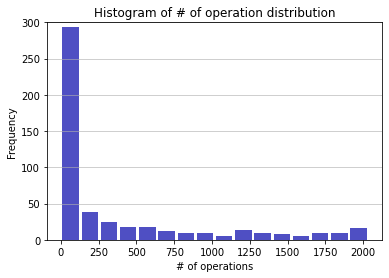

NR15_bb.txt
	mean=10585.81
	var=345174951.361
	max=65509
	min=1


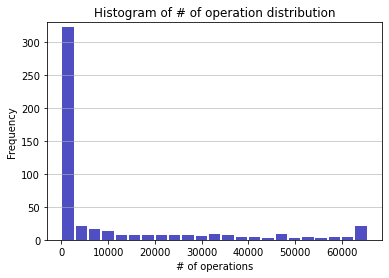

NR4_bb.txt
	mean=10.05
	var=64.525
	max=30
	min=1


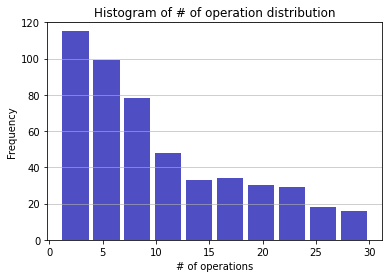

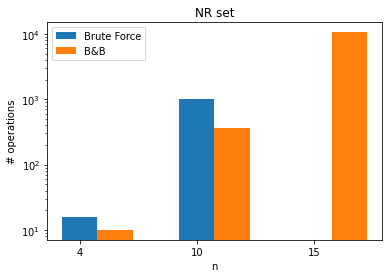

In [26]:
a = Analyzer()
a.analyze("NR")